In [1]:
import cvxpy as cp # python 3.7 로 해야.... 하루종일 걸려서 발견...
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import pickle 

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

from IPython.display import Image


In [2]:
from labelling import XYGeneration

# Dataloading

## X loading 

In [3]:

def pd_setting(dataframe):
    dataframe.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)
    dataframe['Date'] = dataframe.Date.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d') )
    dataframe = dataframe.set_index(['Date'])

    return dataframe

In [4]:
price_df = pd_setting(pd.read_csv("./data/features/price_df.csv"))
mu_df = pd_setting(pd.read_csv("./data/features/mu_df.csv"))
sigma_df = pd_setting(pd.read_csv("./data/features/sigma_df.csv"))

In [5]:
price_df.shape

(7931, 27)

## Y loading

In [6]:
feat_date = list(price_df.index)

In [7]:
dff = pd.read_csv("./data/df_XY.csv")
dff.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)
dff['Date'] = dff.Date.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d') )
dff = dff.set_index(['Date'])

dfy = dff.loc[feat_date]
# extracting Y columns
Y_col = [x for x in dfy.columns if x[-2:]=='_Y']
dfy = dfy[Y_col]

In [8]:
dfy.shape

(7931, 9)

# XY Generation
- df_target : dfy
- df_intput : price_df, mu_df, sigma_df

## Scaling

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [10]:
dff_col_name = price_df.columns

In [11]:
dff.shape

(8184, 27)

In [12]:
price_df.shape

(7931, 27)

In [13]:
def scaler(df):
    df_col_name = df.columns
    feat_date = list(df.index)

    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(df)
    df_mm = min_max_scaler.transform(df)
    df_mm = pd.DataFrame(df_mm, columns = df_col_name, index = feat_date)
    
    return df_mm

In [14]:
#### scaling ####
price_df_mm = scaler(price_df)
mu_df_mm = scaler(mu_df)
sigma_df_mm = scaler(sigma_df)

# Dataset Generation & Labelling

In [15]:
# in_past_seq < tr_past_seq
in_past_seq = 240 # 6 months  
tr_past_seq = 253 # pr1yr
rf = 0.02

In [16]:
# Loading generator
generator = XYGeneration(dfy, tr_past_seq, rf)

# Y labelling 
Y, Y_date, Y_tot_date = generator.Y_generation()

### X concatenation 

In [17]:
# feature slicing & date slicing 
x_p, X_date = generator.X_generation(price_df_mm, in_past_seq)
x_m, _ = generator.X_generation(mu_df_mm, in_past_seq)
x_s, _ = generator.X_generation(sigma_df_mm, in_past_seq)

In [18]:
# features concatenating
X = []
for i in range(len(X_date)):
    x_p_arr = np.expand_dims(x_p[i], -1)
    x_m_arr = np.expand_dims(x_m[i], -1)
    x_s_arr = np.expand_dims(x_s[i], -1)
    
    X_arr = np.concatenate([x_p_arr, x_m_arr, x_s_arr], axis = -1)
    
    X.append(X_arr)
    

# DataLoader

- TESTING
- one-step ahead validation 

<img src="img/one step ahead validation.png" width="800" height="400">

In [19]:
from torch.utils.data import DataLoader
import torch

In [20]:
one_step_ahead = 0 

In [21]:
len(X)

353

In [22]:
len(X_date[0])

240

In [23]:
num_nodes = X[0].shape[1]
feat_dim = X[0].shape[-1]

# num_val = round(num_train*0.2)
num_samples = len(X)
num_train = round(len(X)*0.7) + one_step_ahead
# num_test = num_samples - num_train

num_test = 1

## train & test split
x_train, y_train = X[:num_train], Y[:num_train]
# x_val, y_val = X[num_train : num_train+num_val], Y[num_train : num_train+num_val]
x_test , y_test = X[num_train : num_train+1], Y[num_train : num_train+1]

In [24]:
num_samples - num_train

106

In [25]:

train_date_x, train_date_y = X_date[:num_train], Y_date[:num_train]
# 미래 한달 
test_date_x, test_date_y = X_date[num_train:num_train+1], Y_date[num_train:num_train+1]
test_date_tot_y = Y_tot_date[num_train:num_train+1] # labelling 계산할 때 씌인 기간 

In [26]:
len(Y_date)

353

In [27]:
len(test_date_tot_y[0])

274

In [28]:
train_iter = ([(torch.from_numpy(x).float(),torch.from_numpy(y).float()) for x,y in zip(x_train, y_train)])
# val_iter = ([(torch.from_numpy(x).float(),torch.from_numpy(y).float()) for x,y in zip(x_val, y_val)])
test_iter = ([(torch.from_numpy(x).float(),torch.from_numpy(y).float()) for x,y in zip(x_test, y_test)])


In [29]:
### dataloader
train_dataloader = DataLoader(train_iter, batch_size=12, shuffle=True, drop_last = True)
# valid_dataloader = DataLoader(val_iter, batch_size=12, shuffle=True, drop_last = True)
test_dataloader = DataLoader(test_iter, batch_size=1, shuffle=True, drop_last = True)

# Model 

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable




class LSTM_Model(nn.Module):
    
    def __init__(self, X_assets_num, past_seq, Y_asset_num, dim_num, num_layers, device):
        super(LSTM_Model, self).__init__()
        self.embedding_in_dim = dim_num
        self.num_layers = num_layers
        
        self.lstm_in_dim = X_assets_num
        self.lstm_out_dim = X_assets_num 
        
        self.fc_in_dim = past_seq
    
        self.fc2_out_dim = Y_asset_num
        self.embedding = nn.Conv2d(self.embedding_in_dim, 1, kernel_size = (1,1))
        self.lstm = nn.LSTM(self.lstm_in_dim, self.lstm_out_dim, num_layers = self.num_layers, batch_first = True)
        self.fc = nn.Conv2d(self.fc_in_dim, 1, kernel_size= (1,1))
        self.fc2 = nn.Conv2d(self.lstm_out_dim, self.fc2_out_dim, kernel_size = (1,1))
#         self.fc = nn.Conv2d(self.fc_out_dim, self.fc_out_dim, kernel_size= (1,1))
        
        
    def forward(self, x):
        batch_size = x.size(0)
        
        x = x.transpose(3,1)
        x = self.embedding(x)
        x = x.transpose(1,3)
        if x.shape[0] != 1:
            x = x.squeeze() # [b, L, N]
        else:
            x = torch.squeeze(x, 3)
        hidden_init = torch.zeros(self.num_layers, batch_size, self.lstm_out_dim).to(device)
        cell_init = torch.zeros(self.num_layers, batch_size, self.lstm_out_dim).to(device)
#         print (x.shape)
        output, hidden = self.lstm(x, (hidden_init, cell_init))
        output = output.unsqueeze(-1) # [b, L, n, 1]
    
        prediction = self.fc(output).permute(0,2,1,3) # [b, 1, n, 1] --> [b,n,1,1]
        prediction = self.fc2(prediction).transpose(1,3) 
                # [b,n,1,1] --> [b,9,1,1] --> [b,n,1,1] --> [b,1,1,9]
        prediction = prediction.squeeze()       
        
        return prediction         
        



In [34]:
device = torch.device("cuda:1")
num_nodes = 27

past_seq = 240
Y_asset_num = 9

dim_num = 3
num_layers = 1

learning_rate = 0.001
wdecay = 0.001

In [35]:
# model 
model = LSTM_Model(num_nodes, past_seq, Y_asset_num, dim_num, num_layers, device)
model.to(device) # model loading

criterion = torch.nn.L1Loss() # MAE 
# criterion = torch.nn.MSELoss() # MSE 

# criterion = torch.nn.L1Loss() # MAE 
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = wdecay)

# Training

In [36]:
num_epochs = 50

loss_train = []
loss_valid = []

for epoch in range(1, num_epochs+1):
    model.train()

    epoch_train_loss = [] # loss average for one epoch
    epoch_valid_loss = []
##### training 
    for data in train_dataloader:
        optimizer.zero_grad()

        train_X, train_Y = data

        train_X = torch.Tensor(train_X).to(device)
        train_Y = torch.Tensor(train_Y).to(device)
#         print ('X : ', train_X.size())
#         print ('Y : ', train_Y.size())
        train_out = model(train_X)
#         print ('out : ', train_out.size())

#         print('out: ',train_out.size())

        loss = criterion(train_out,train_Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss.append(loss.item())

    loss_train.append(np.mean(epoch_train_loss))
    
# ##### validation 
#     for data in valid_dataloader:
#         valid_X, valid_Y = data
#         valid_X = valid_X.transpose(3,1)
#         valid_X = nn.functional.pad(valid_X, (kernel_size-1,0,0,0))
        
#         valid_X = torch.Tensor(valid_X).to(device)
#         valid_Y = torch.Tensor(valid_Y).to(device)
        
#         valid_out, _ = model(valid_X)
#         valid_out = valid_out.squeeze()
        
#         loss = criterion(valid_out, valid_Y)
        
#         epoch_valid_loss.append(loss.item())
#     loss_valid.append(np.mean(epoch_valid_loss))
    
#     if epoch%50 == 0:
#         print ("Epoch {}| tarin loss : {}, valid loss : {}".format(epoch,np.mean(epoch_train_loss), np.mean(epoch_valid_loss)))
    
    if epoch%10 == 0:
        print ("Epoch {}| tarin loss : {}".format(epoch,np.mean(epoch_train_loss)))

Epoch 10| tarin loss : 0.004407622758299113
Epoch 20| tarin loss : 0.0023964386607985945
Epoch 30| tarin loss : 0.0017583537497557699
Epoch 40| tarin loss : 0.002288015856174752
Epoch 50| tarin loss : 0.003186258499044925


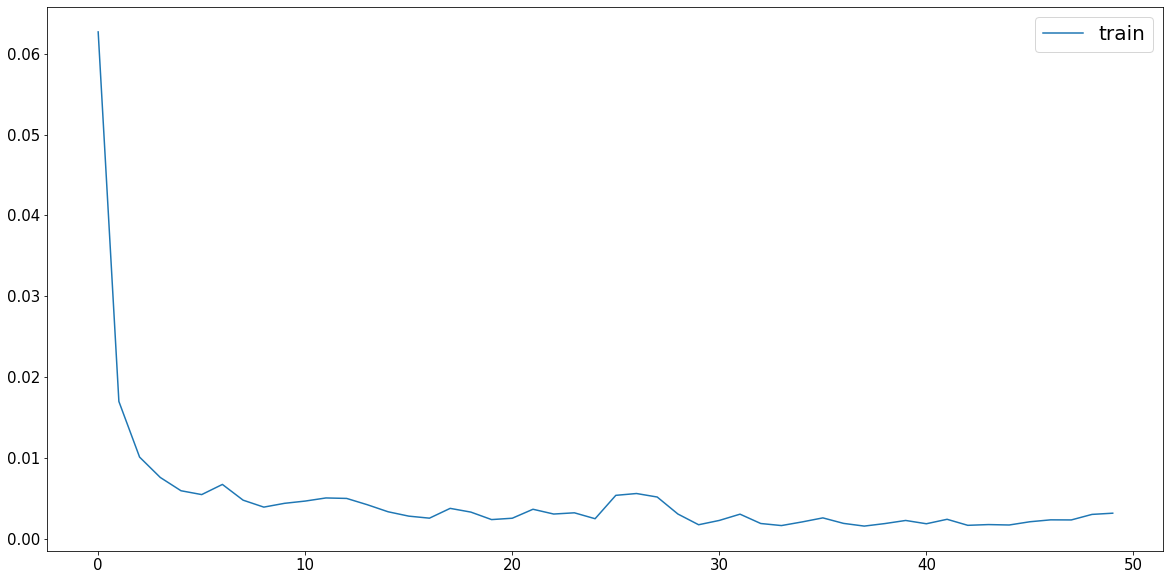

In [37]:
plt.figure(figsize = (20,10))
plt.plot(loss_train, label = 'train')
# plt.plot(loss_valid, label = 'valid')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = (20))

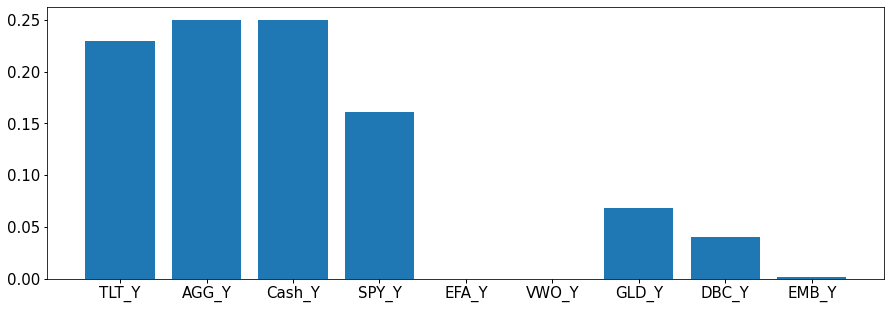

In [38]:
plt.figure(figsize = (15,5))
plt.bar(Y_col,train_Y[10].detach().cpu())
plt.tick_params(width=1)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [39]:
train_out[10].detach().cpu()

tensor([ 0.2327,  0.2539,  0.2554,  0.1666,  0.0011, -0.0012,  0.0639,  0.0404,
        -0.0024])

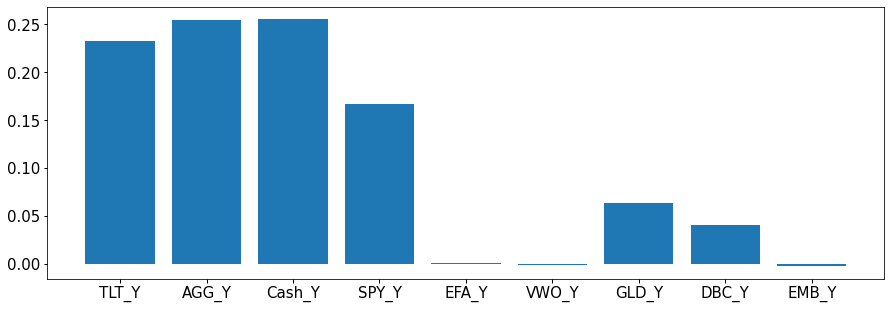

In [40]:
plt.figure(figsize = (15,5))
plt.bar(Y_col,train_out[10].detach().cpu())
plt.tick_params(width=1)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

# Testing 
- one-step ahead validation 

<img src="img/one step ahead validation.png" width="800" height="400">

In [42]:
model.eval()

test_loss = []
##### TESTING ##############
for data in test_dataloader:
    test_X, test_Y = data
    test_X = torch.Tensor(test_X).to(device)
    test_Y = torch.Tensor(test_Y).to(device)

    test_out = model(test_X)
    
    loss = criterion(test_out, test_Y)

    test_loss.append(loss.item())


    
# loss_valid.append(np.mean(epoch_valid_loss))


In [45]:
import os
output_dir = './RESULT/LSTM_120_seq'
os.path.join(output_dir,'result')

'./RESULT/LSTM_120_seq/result'

In [43]:
test_loss

[0.004314220044761896]

In [ ]:
z = torch.rand((1,2,3,1))


# Saving values
- three lists 
     1. [pred weight, 수익률, volatility]
     2. [true weight, 수익률, volatility]
     3. [loss, future 1 month date, columns] 
  
- 수익률, volatility
    - 정해진 weight 로 미래 한달간 가격에 대한 weighted log-return 


In [ ]:
def return_volatility(df_bench):
    '''
    return & volatility
    '''  
    logret = np.log(df_bench/df_bench.shift(1)).dropna()
    T = logret.shape[0]

    sigma = logret.cov() * T # annualize sigma (check again)
    mu = logret.mean()*T

    return mu, sigma

In [ ]:
dfy

In [ ]:
### 라벨링 할 때 쓰였던 동일한 기간에 대한 수익률과 volatility 구한다. 
# price slicing
test_price = dfy.loc[test_date_tot_y[0][0]:test_date_tot_y[0][-1]]
# test_price = dfy.loc[test_date_y[0][0]:test_date_y[0][-1]]
# bench mu, volatility calculation 
test_mu, test_sigma = return_volatility(test_price)

In [ ]:
test_price.plot()

In [ ]:
test_sigma

In [ ]:
# weight setting
pred_w = test_out.detach().cpu()[0].numpy()
true_w = test_Y.detach().cpu()[0].numpy()

### mu, sigma rebalancing


In [ ]:
# mu
pred_mu = round(pred_w.dot(test_mu.values), 5)
true_mu = round(true_w.dot(test_mu.values), 5)

# sigma
pred_sigma = round(np.sqrt(pred_w.dot(test_sigma.values).dot(pred_w.T)), 5)
true_sigma = round(np.sqrt(true_w.dot(test_sigma.values).dot(true_w.T)), 5)

In [ ]:
true_sigma

## Saving as one dataframe

In [ ]:
fold_dict = {}
fold_dict['Date']= ([[test_date_y[0][0], test_date_y[0][-1]]])
# fold_dict['X_date'] = ([[test_date_x_m[0], test_date_x_m[-1]]])
fold_dict['pred_w']= [list(pred_w)]
fold_dict['pred_mu']= pred_mu
fold_dict['pred_sigma']=pred_sigma
fold_dict['true_w']=[list(true_w)]
fold_dict['true_mu']=true_mu
fold_dict['true_sigma']=true_sigma
fold_dict['test_loss(%)']=round(test_loss[0], 4)*100


In [ ]:
a = pd.DataFrame.from_dict(fold_dict)

In [ ]:
a

In [ ]:
with open("./RESULT/result_{}.pickle".format(1), 'wb') as f:
    pickle.dump(a, f)

In [ ]:
with open("./RESULT/result_{}.pickle".format(1), 'rb') as f:
    res = pickle.load(f)

In [ ]:
pd.DataFrame(pd.read_pickle("./RESULT/result_{}.pickle".format(1)))

In [ ]:
df = pd.DataFrame(pd.read_pickle(os.path.join(event_speed_path, f_name)))
    

In [ ]:
test_price.plot()

In [ ]:
list(dff.columns).index('Cash_Y')

In [ ]:
list(dff.columns)

In [ ]:
adp[20]

In [ ]:
test_out.detach().cpu()[0]

In [ ]:
test_Y.detach().cpu()[0]

In [ ]:
test_out.detach().cpu()[0]

In [ ]:

plt.figure(figsize = (15,5))
plt.bar(Y_col,test_out.detach().cpu()[0])
plt.tick_params(width=1)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.title("{}~{}".format(test_date_y[0][0],test_date_y[0][1]))
plt.show()

In [ ]:
test_Y.detach().cpu()